In [1]:
# ================================================================================================================
# Figure 1: Bootstrap resampling and extreme rainfall distribution
# Purpose: Illustrate sampling uncertainty in the maximum annual Rx1d rainfall values using bootstrap resampling.
# Inputs: Weather@Home Rx1d dataset (stationary 2006–2015 ensemble), 3226 model years.
# Outputs: Plot of 10,000 bootstrap-sampled maxima with GEV-based return levels and percentile annotations.
# ================================================================================================================

-------

In [2]:
# ---------------------------------------------------------------
# Section 1: Import required libraries
# ---------------------------------------------------------------

from scipy.stats import genextreme as gev
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

# Set default plot font for consistency
plt.rcParams["font.family"] = "Arial"

-------

In [3]:
# ---------------------------------------------------------------
# Section 2: Load Rx1d rainfall data
# ---------------------------------------------------------------

# Load the Weather@Home Rx1d data (stationary 2006–2015 ensemble)
rainfall_data = xr.open_dataset('../Weather@home Data/Aotearoa Rx1d Weather@home Data Specified Land-Sea Mask - Stationary Climate.nc')['item5216_daily_mean']

# Convert to numpy arrays
rx1d_data = np.array(rainfall_data)
latitude = np.array(rainfall_data['global_latitude0'])
longitude = np.array(rainfall_data['global_longitude0'])

-------

In [4]:
# ---------------------------------------------------------------
# Section 3: Define bootstrap resampling function
# ---------------------------------------------------------------

def bootstrap_random_sample(import_data):
    """
    Perform bootstrap resampling of Rx1d data to estimate the distribution of worst-in-century (WIC).

    Parameters
    ----------
    import_data : Input series of annual Rx1d values for a given grid cell.

    Returns
    -------
    df_result : DataFrame containing the maximum value from each of 10,000 bootstrap samples (column 'WIC').
    """

    num_samples = 100        # Number of data points per bootstrap sample
    num_iterations = 10000   # Total number of bootstrap iterations
    
    # Perform bootstrap and store results
    result = [] 

    if import_data is not None:
        for _ in range(num_iterations):
            bootstrap_sample = resample(import_data, n_samples=num_samples, replace=True)
            result.append(np.max(bootstrap_sample))
    else:
        result = None

    # Convert results to a DataFrame
    df_result = pd.DataFrame()
    df_result['WIC'] = pd.DataFrame(result) if result is not None else pd.Series([np.nan] * num_samples)

    return df_result

-------

In [5]:
# ---------------------------------------------------------------
# Section 4: Bootstrap resampling and percentile estimation
# ---------------------------------------------------------------

# Select a representative grid cell for rx1d data (Northland region): Latitude index = 12, Longitude index = 27
rx1d_selected_grid_cell = rx1d_data[:,12,27]

# Generate 10,000 bootstrap-sampled maxima
bootstrap_rx1d_selected_grid_cell = bootstrap_random_sample(rx1d_selected_grid_cell)

# Estimate selected percentiles (1st, 50th, 99th)
p1 = np.percentile(bootstrap_rx1d_selected_grid_cell['WIC'], 1)
p99 = np.percentile(bootstrap_rx1d_selected_grid_cell['WIC'], 99)
p50 = np.percentile(bootstrap_rx1d_selected_grid_cell['WIC'], 50)

# Sort the bootstrap results for plotting
sort_bootstrap_rx1d_selected_grid_cell = bootstrap_rx1d_selected_grid_cell.sort_values(by='WIC').reset_index().drop(['index'], axis=1)

-------

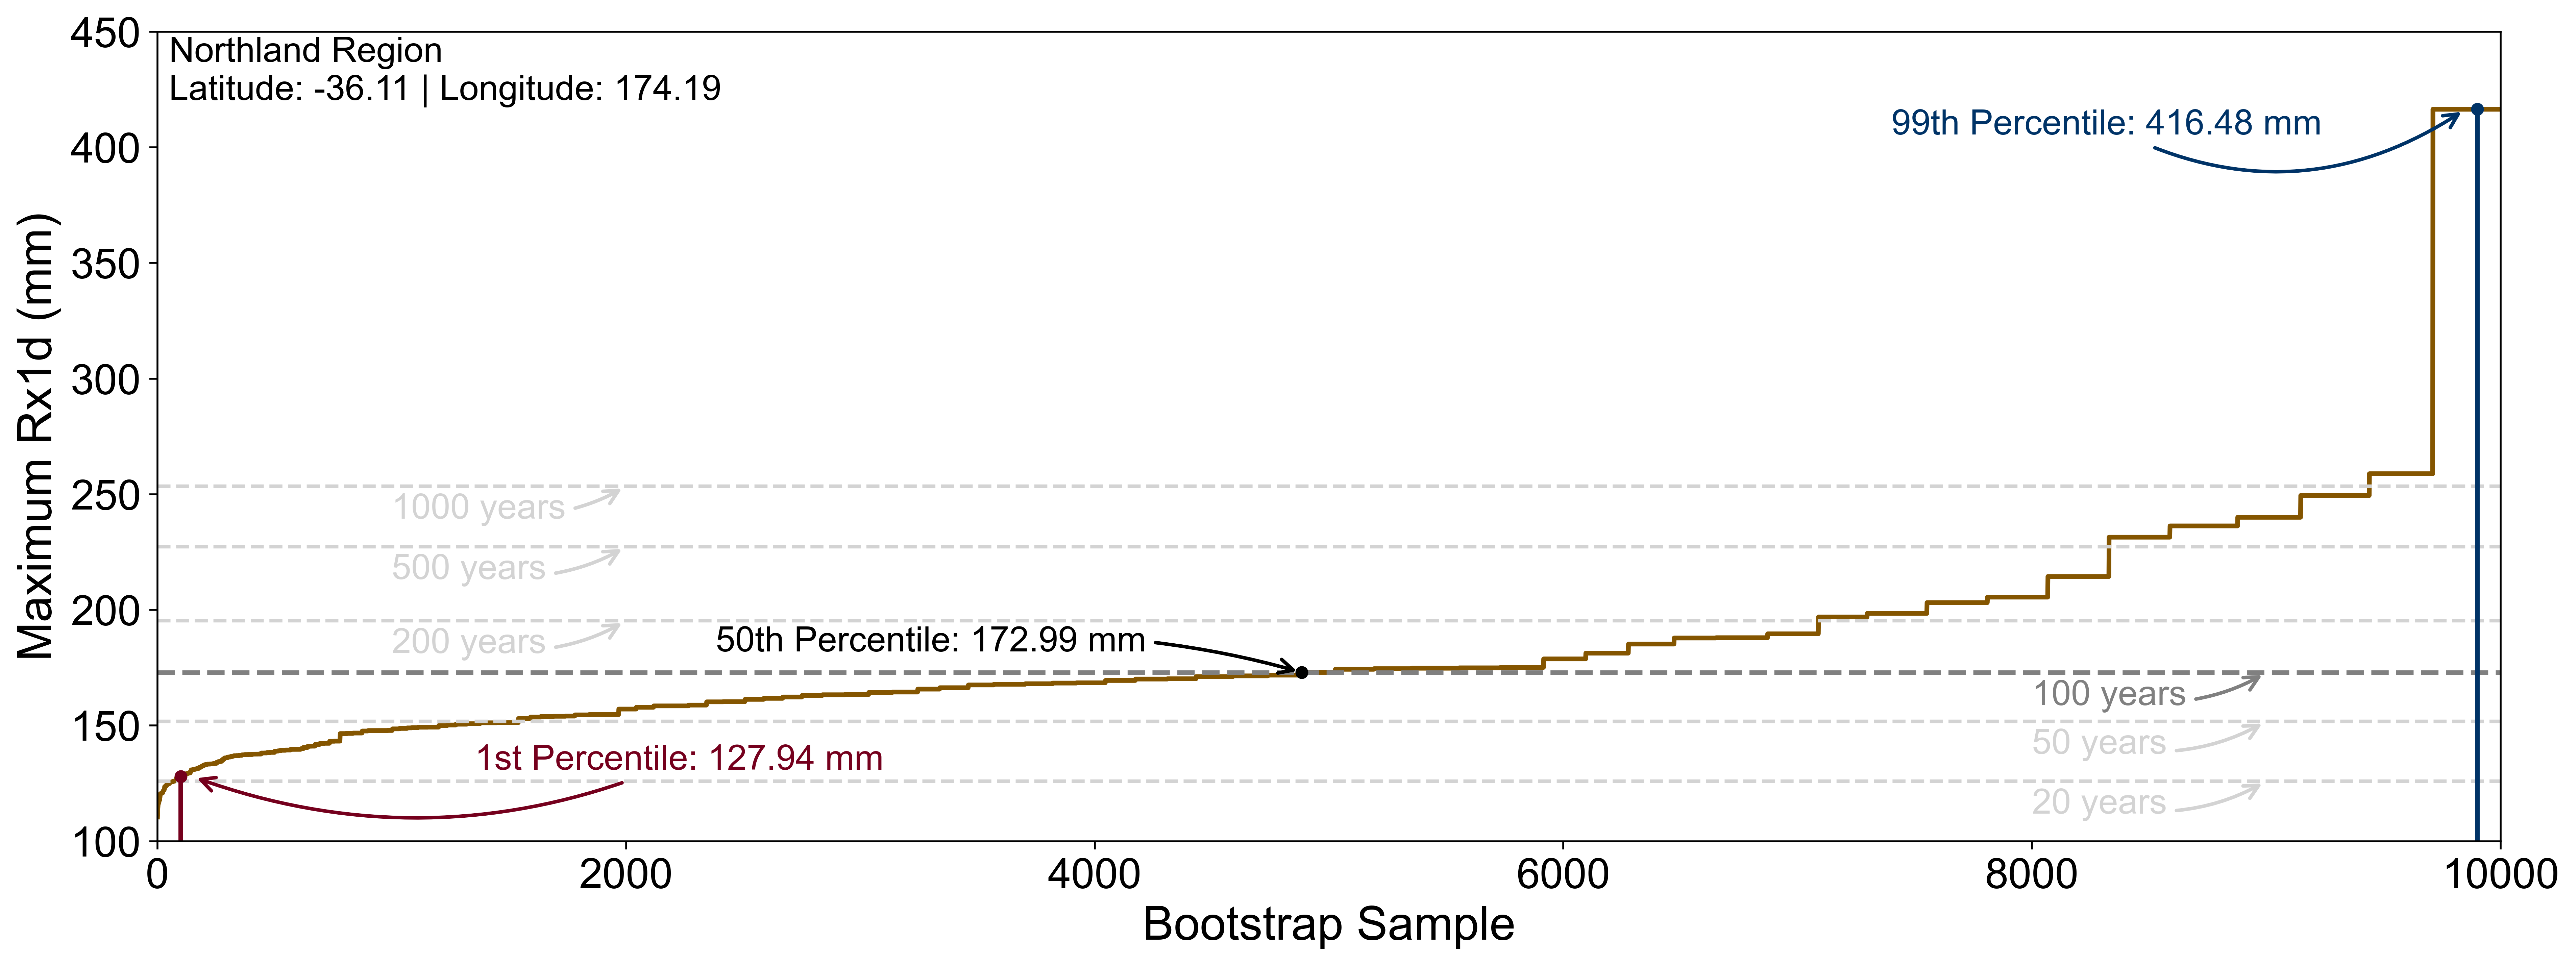

In [6]:
# ---------------------------------------------------------------
# Section 5: Plot bootstrap distribution and return levels
# ---------------------------------------------------------------

fig = plt.figure(figsize=(15, 6), dpi=500)

# Plot bootstrap-sampled maxima in ascending order
plt.plot(sort_bootstrap_rx1d_selected_grid_cell.index, sort_bootstrap_rx1d_selected_grid_cell, color='#845500', linewidth=2)

# Configure y-axis and labels
plt.ylim(100, 450)
yticks_amount = list(range(100, 450 + 1, 50))
plt.yticks(yticks_amount)
plt.xlabel("Bootstrap Sample", fontsize=20)
plt.ylabel("Maximum Rx1d (mm)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Annotate grid-cell location
plt.text(0.07, 0.925, 'Northland Region' + '\n' + 'Latitude: ' f"{latitude[12,27]:.2f}" + ' | Longitude: ' f"{longitude[12,27]:.2f}", 
         transform=plt.gcf().transFigure, fontsize=15, va='top', ha='left')



# ---------------------------------------------------------------
# Add GEV-based return levels for reference
# ---------------------------------------------------------------
shape, loc, scale = gev.fit(rx1d_selected_grid_cell, 0)
return_periods = [20, 50, 200, 500, 1000]
return_periods_labels = ['20 years', '50 years', '200 years', '500 years', '1000 years']
return_periods_labels_positions = [9000, 9000, 2000, 2000, 2000]

# Plot return levels for each specified return period
for index in range (0,5):
    period = return_periods[index]
    return_level = gev.ppf(1 - 1/period, shape, loc=loc, scale=scale)
    plt.hlines(return_level, xmin=0, xmax=10000, color='lightgray', linestyle='--', alpha=1, linewidth=1.5)
    plt.annotate(return_periods_labels[index], xy=(return_periods_labels_positions[index], return_level), xycoords='data',
                 xytext=(return_periods_labels_positions[index] - 1000, return_level - 3), textcoords='data',
                 arrowprops=dict(arrowstyle="->", color='lightgray', linewidth=1.5, connectionstyle="arc3,rad=0.2"),
                 color='lightgray', fontsize=15, verticalalignment='top', horizontalalignment='left')

# Highlight 100-year return level separately
true_return_level = gev.ppf(1 - 1/100, shape, loc=loc, scale=scale)
true_pooled_legend_line = plt.hlines(true_return_level, xmin=0, xmax=10000, color='gray', linestyle='--', 
                                      alpha=1, linewidth=2, label='Pooled est. (100 years)')
plt.annotate(f"100 years", xy=(9000, true_return_level), xycoords='data', xytext=(9000 - 1000, true_return_level - 3), textcoords='data',
             arrowprops=dict(arrowstyle="->", color='gray', linewidth=1.5, connectionstyle="arc3,rad=0.2"),
             color='gray', fontsize=15, verticalalignment='top', horizontalalignment='left')

# ---------------------------------------------------------------
# Annotate 1st, 50th, and 99th percentiles of bootstrap samples
# ---------------------------------------------------------------
x_1st = (sort_bootstrap_rx1d_selected_grid_cell['WIC'] - p1).abs().idxmin()
x_50th = (sort_bootstrap_rx1d_selected_grid_cell['WIC'] - p50).abs().idxmin()
x_99th = 9900

# 1st, 50th, and 99th percentiles
plt.scatter(x_1st, p1, color='#75001d', s=20, zorder=3, label='1st percentile')
plt.scatter(x_50th, p50, color='black', s=20, zorder=3)
plt.scatter(x_99th, p99, color='#003367', s=20, zorder=3, label='99th percentile')
plt.vlines(x=x_1st, ymin=0, ymax=p1, color='#75001d', linewidth=2, label='1st percentile')
plt.vlines(x=x_99th, ymin=0, ymax=p99, color='#003367', linewidth=2, label='99th percentile')


# Annotate percentiles
plt.annotate(f"1st Percentile: {p1:.2f} mm", xy=(x_1st + 50, p1), xycoords='data', xytext=(x_1st + 3000, p1 - 0), textcoords='data',
             arrowprops=dict(arrowstyle="->", color='#75001d', linewidth=1.5, connectionstyle="arc3,rad=-0.2"),
             color='#75001d', fontsize=15, verticalalignment='bottom', horizontalalignment='right')
plt.annotate(f"50th Percentile: {p50:.2f} mm", xy=(x_50th, p50), xycoords='data', xytext=(x_50th - 2500, p50 + 20), textcoords='data',
             arrowprops=dict(arrowstyle="->", color='black', linewidth=1.5, connectionstyle="arc3,rad=-0.1"),
             color='black', fontsize=15, verticalalignment='top', horizontalalignment='left')
plt.annotate(f"99th Percentile: {p99:.2f} mm", xy=(x_99th - 50, p99), xycoords='data', xytext=(x_99th - 2500, p99 - 0), textcoords='data',
             arrowprops=dict(arrowstyle="->", color='#003367', linewidth=1.5, connectionstyle="arc3,rad=0.3"),
             color='#003367', fontsize=15, verticalalignment='top', horizontalalignment='left')


# Final layout and display
plt.grid(False)
plt.margins(x=0)
plt.tight_layout()
plt.show()